# 3W - Strategy Thinking project

In [1]:
# IMPORTS AND CONFIGURATIONS

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# import pandas_profiling
# from pandas_profiling import ProfileReport

import glob
import os

## Data Preparation

Preprocessing a dataset through data characterisation involves summarising the features and characteristics present in the data using statistical measures and visualisations techniques such as bar charts and scatter plots. After this stage, it should be possible to identify biases, patterns, trends, and any missing or irrelevant data in the data set that may need to be addressed.

This dataset is composed by instances of eight types of undesirable events characterized by eight process variables from three different sources: real instances, simulated instances and hand-drawn instances. All real instances were taken from the plant information system that is used to monitor the industrial processes at an operational unit in Brazilian state of Espírito Santo. The simulated instances were all generated using OLGA ([Schlumberger](https://www.software.slb.com/products/olga)), a dynamic multiphase flow simulator that is widely used by oil companies worldwide (Andreolli, 2016). Finally, the hand-drawn instances were generated by a specific tool developed by Petrobras researchers for this dataset to incorporate undesirable events classfied as rare. 
 
### Data Characterisation
The data consists of over 50 million observations, with 13 columns of data for each observation. The first column, `label`, indicates the event type for each observation. The second column, `well`, contains the name of the well the observation was taken from. Hand-drawn and simulated instances have fixed names for in this column, while real instances have names masked with incremental id. The third column, `id`, is an identifier for the observation and it is incremental for hand-drawn and simulated instances, while each real instance has an id generated from its first timestamp. The columns representing the process variables are:

* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG) - installed on Christmas Tree;
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT) - installed on Christmas Tree;
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP) - located on platform;
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;

The pressure features are measured in Pascal (Pa), the volumetric flow rate features are measured in standard cubic meters per second (SCM/s), and the temperature features are measured in degrees Celsius (°C).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type) - target variable;
* **well**: well name. Hand-drawn and simulated instances have fixed names (respectively, `drawn` and `simulated`. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp;
* **class**: Although it can be used to identify periods of normal operation, fault transients, and faulty steady states, which can help with diagnosis and maintenance, it is a category which results from label, which is our target here

The labels are:
* 0 - Normal Operation = `Normal`
* 1 - Abrupt Increase of BSW = `AbrIncrBSW`
* 2 - Spurious Closure of DHSV = `SpurClosDHSW`
* 3 - Severe Slugging = `SevSlug`
* 4 - Flow Instability = `FlowInst`
* 5 - Rapid Productivity Loss = `RProdLoss`
* 6 - Quick Restriction in PCK	= `QuiRestrPCK`
* 7 - Scaling in PCK = `ScalingPCK`
* 8 - Hydrate in Production Line = `HydrProdLine`

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/petrobras/3W/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/petrobras/3W/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

In order to maintain the realistic aspects of the data, the dataset was extracted without preprocessing, including the presence of `NaN` values, frozen variables due to sensor or communication issues, instances with varying sizes, and outliers (R.E.V. Vargas, et al. 2019). 

From all 50,822,124 entries, 3,086,851 are duplicated, that is, approximately 6.07% of total. These duplicated rows may be related to frozen variables from real instances, as simulated and hand-drawn instances are naturally free of such problems. Although no missing values were found for columns `label`, `well`, and `id`, other features presented null or absent values. Notably, the column `T-JUS-CKGL` turned out to be completely empty.

In [2]:
df = pd.read_csv('3Wdataset_real.csv', index_col=None)

# only using real, since simulated and drawn doesnt have QGL and P-JUS-CKGL
# df_real.info()

# df_drawn = pd.read_csv('3Wdataset_drawn.csv', index_col=None)
# # df_drawn.info()

# df_sim1 = pd.read_csv('3Wdataset_simulated_1of2.csv', index_col=None)
# # df_sim1.info()

# df_sim2 = pd.read_csv('3Wdataset_simulated_2of2.csv', index_col=None)
# # df_sim2.info()

# df = pd.concat([
#     df_real,
#     df_sim1,
#     df_sim2,
#     df_drawn
# ])

# df = df.drop('source', axis=1)

# dismissing temporary DFs to release memory
# del df_sim1
# del df_sim2
# del df_real
# del df_drawn

df.shape

(13952911, 14)

### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13952911 entries, 0 to 13952910
Data columns (total 14 columns):
 #   Column      Dtype  
---  ------      -----  
 0   timestamp   object 
 1   label       int64  
 2   well        object 
 3   id          int64  
 4   P-PDG       float64
 5   P-TPT       float64
 6   T-TPT       float64
 7   P-MON-CKP   float64
 8   T-JUS-CKP   float64
 9   P-JUS-CKGL  float64
 10  T-JUS-CKGL  float64
 11  QGL         float64
 12  class       float64
 13  source      object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.5+ GB


In [18]:
# Finding missing values
missing = df.isnull()
missing.sum()

total_missing = df.isnull().sum()
percent_missing = total_missing * 100 / len(df)
missing_value_df = pd.DataFrame({'percent': percent_missing, 'total':total_missing})

missing_value_df

,percent,total
timestamp,0.000000,0
label,0.000000,0
well,0.000000,0
id,0.000000,0
P-PDG,0.042106,5875
P-TPT,0.044321,6184
T-TPT,0.044335,6186
P-MON-CKP,8.038667,1121628
T-JUS-CKP,11.550980,1611698
P-JUS-CKGL,28.276702,3945423


In [7]:
# generating report
# from dataprep.eda import plot, plot_missing, plot_correlation, create_report
# report = create_report(df)
# report.show_browser()

import sweetviz as sv
report = sv.analyze(df)
report.show_html()

                                             |                         | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [19]:
df.head()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,source
0,2017-06-25 22:01:27,0,WELL-00002,20170625220127,0.0,8698015.0,117.6015,2142158.0,75.63453,2310426.0,NaN,0.0,0.0,real
1,2017-06-25 22:01:28,0,WELL-00002,20170625220127,0.0,8698015.0,117.6014,2172395.0,75.65491,2310427.0,NaN,0.0,0.0,real
2,2017-06-25 22:01:29,0,WELL-00002,20170625220127,0.0,8698015.0,117.6013,2202631.0,75.67529,2310427.0,NaN,0.0,0.0,real
3,2017-06-25 22:01:30,0,WELL-00002,20170625220127,0.0,8698015.0,117.6012,2180472.0,75.69567,2310427.0,NaN,0.0,0.0,real
4,2017-06-25 22:01:31,0,WELL-00002,20170625220127,0.0,8698015.0,117.6011,2158313.0,75.71606,2310428.0,NaN,0.0,0.0,real


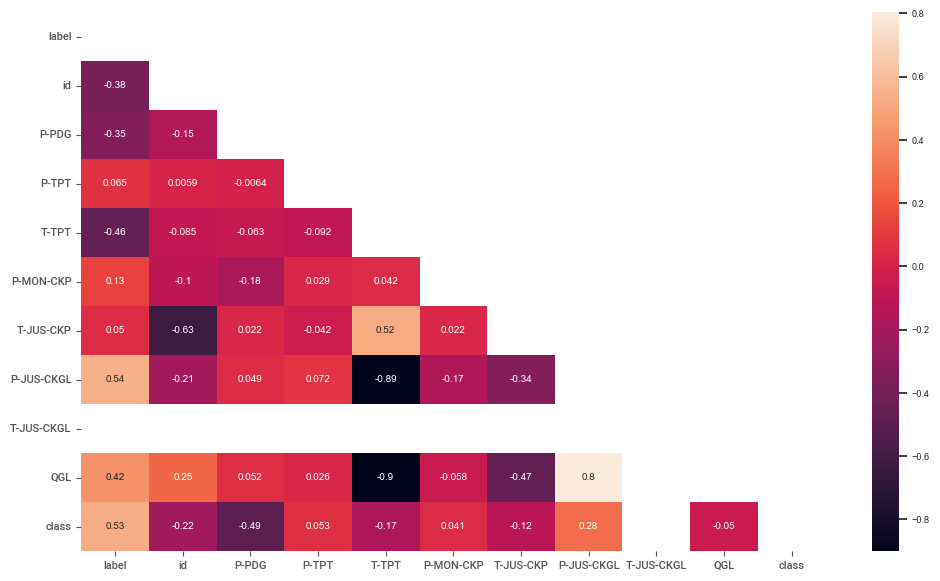

In [9]:
# Computing the correlations
corr = df.corr()

# Creating a boolean mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotting the heatmap with the mask
fig, ax = plt.subplots(figsize=(12, 7))
sns.set(font_scale=0.6)
sns.heatmap(corr, annot=True, mask=mask, ax=ax)
plt.show()

The histogram above shows how the values for T-TPT (temperature variable at the Temperature and Pressure Transducer) are distributed. This variable appears to have a significant correlation with other features and must be considered in further investigations. As it can be seen, it presents values between 100°C and 120°C for the majority of observations, which may indicate that colder temperatures in this equipment are related to issues in the Subsea Christmas Tree operation. 

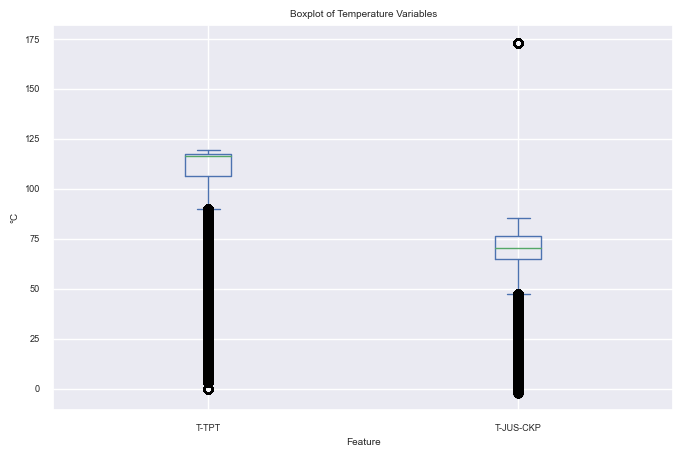

In [10]:
columns = ['T-TPT','T-JUS-CKP']

df[columns].plot(kind='box', figsize=(8, 5))
plt.title('Boxplot of Temperature Variables')
plt.xlabel('Feature')
plt.ylabel('°C')
plt.show()

The boxplots above compare how data is distributed in two features, `T-TPT` and `T-JUS-CKP` (temperature variable downstream of the production choke - CKP). While 50% of observations for `T-TPT` are between 95°C-120°C, `T-JUS-CKP` seems to work on milder conditions, with half of observations between 70°C-85°C.

The boxplots below present how data is distributed in the features measured in Pascal (Pa). As a reference for this analysis, the atmospheric pressure at sea level is approximately 101,325 Pa and the pressure that a body experiences at a 2000 meters below sea level - which is a realistic depth for a oil well in this project context - is approximately 2,061,200 Pa. 

To generate the following boxplots together, it was decided to omit the outlier points, since future analyzes will be necessary to understand the nature of these extraordinary measurements and they could distort the graphs considerably at this point.

From all pressure features, only `P-PDG` (pressure variable at the Permanent Downhole Gauge) presented negative values in its series. The PDG is installed at the bottom of the well and it may measure a negative pressure in pascals if the pressure inside the well is lower than the pressure outside the well, but it also measure values above 30 MPa. 

The features `P-MON-CKP` and `P-JUS-CKGL` - pressure variable upstream of the production choke and of the gas lift choke, respectively - present a more comparable range of values, with approximately half of measurements between 1 MPa and 5 MPa. Also, `P-TPT`(pressure variable at the Temperature and Pressure Transducer), presents the most symetric distribution among all 4 pressure features, which indicates that the data is closer to a normal distribution than in other features, with the median approximately 15 MPa.</s>

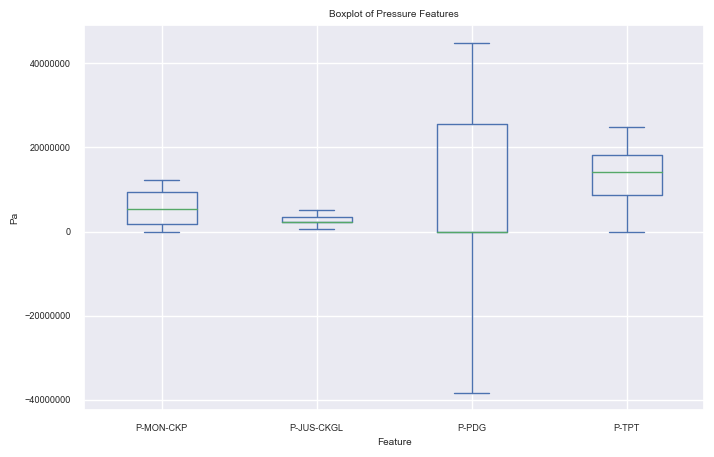

In [11]:
columns = ['P-MON-CKP','P-JUS-CKGL','P-PDG','P-TPT'] 
df[columns].plot(kind='box', figsize=(8, 5), showfliers=False)
plt.title('Boxplot of Pressure Features')
plt.xlabel('Feature')
plt.ylabel('Pa')
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.show()

Finally, it was observed that `QGL` data (gas lift flow rate) is heavily concentrated at the range 0.0 SCM/s-0.2 SCM/s with more almost 10 million rows, while other ranges do not present more than 1 million observations. To illustrate how it is distributed throughout all ranges, it was decided to use log scale on y-axis (Frequency) for the following histogram.

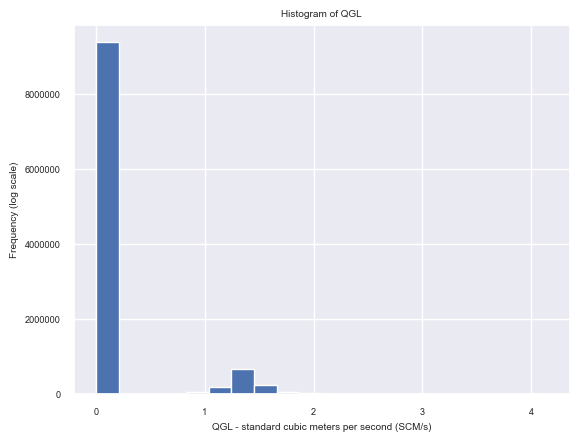

In [12]:
column = 'QGL'
df[column].plot(kind='hist', bins=20)
plt.title('Histogram of {}'.format(column))
plt.xlabel(f'{column} - standard cubic meters per second (SCM/s)')
plt.ylabel('Frequency (log scale)')

# plt.semilogy() # to set the y-axis to log scale

# def y_formatter(y, pos):
#     return f'{y:.0f}'

# formatter = FuncFormatter(y_formatter)
# ax = plt.gca()
# ax.yaxis.set_major_formatter(formatter)

plt.show()

### Data Cleaning

In [20]:
# drop rows with missing or null class column
df = df.dropna(subset=['P-PDG','P-TPT','T-JUS-CKP','P-MON-CKP','T-TPT','P-MON-CKP','QGL','P-JUS-CKGL'])

# first interaction will dismiss timestamp in order to remove duplicates, even if it overlooks frozen
# variables due to sensor or communication issues
# T-JUS-CKGL is empty
# removing class, since it results from label
# removing ID from df

df = df.drop(['timestamp', 'T-JUS-CKGL', 'class', 'id'], axis=1)

# checking duplicated rows after removing timestamp and ids
df = df.drop_duplicates()

df.shape

(9959550, 10)

### Feature Engineering

In [21]:
# Change 'label' column to object dtype
df['label'] = df['label'].astype('object') 

In [22]:
# Create boolean columns for each label
label_dummies = pd.get_dummies(df['label'], prefix='label')
df = pd.concat([df, label_dummies], axis=1)

In [23]:
# Rename boolean columns
column_names = {
    'label_0': 'Normal',
    'label_1': 'AbrIncrBSW',
    'label_2': 'SpurClosDHSW',
    'label_3': 'SevSlug',
    'label_4': 'FlowInst',
    'label_5': 'RProdLoss',
    'label_6': 'QuiRestrPCK',
    'label_7': 'ScalingPCK',
    'label_8': 'HydrProdLine'
}
df = df.rename(columns=column_names)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9959550 entries, 0 to 13952910
Data columns (total 18 columns):
 #   Column        Dtype  
---  ------        -----  
 0   label         object 
 1   well          object 
 2   P-PDG         float64
 3   P-TPT         float64
 4   T-TPT         float64
 5   P-MON-CKP     float64
 6   T-JUS-CKP     float64
 7   P-JUS-CKGL    float64
 8   QGL           float64
 9   source        object 
 10  Normal        uint8  
 11  AbrIncrBSW    uint8  
 12  SpurClosDHSW  uint8  
 13  SevSlug       uint8  
 14  FlowInst      uint8  
 15  RProdLoss     uint8  
 16  QuiRestrPCK   uint8  
 17  ScalingPCK    uint8  
dtypes: float64(7), object(3), uint8(8)
memory usage: 911.8+ MB


In [24]:
# Drop the original 'label' column and Normal column, since all other events must be 0
df = df.drop(['label','Normal'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9959550 entries, 0 to 13952910
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   well          object 
 1   P-PDG         float64
 2   P-TPT         float64
 3   T-TPT         float64
 4   P-MON-CKP     float64
 5   T-JUS-CKP     float64
 6   P-JUS-CKGL    float64
 7   QGL           float64
 8   source        object 
 9   AbrIncrBSW    uint8  
 10  SpurClosDHSW  uint8  
 11  SevSlug       uint8  
 12  FlowInst      uint8  
 13  RProdLoss     uint8  
 14  QuiRestrPCK   uint8  
 15  ScalingPCK    uint8  
dtypes: float64(7), object(2), uint8(7)
memory usage: 826.3+ MB


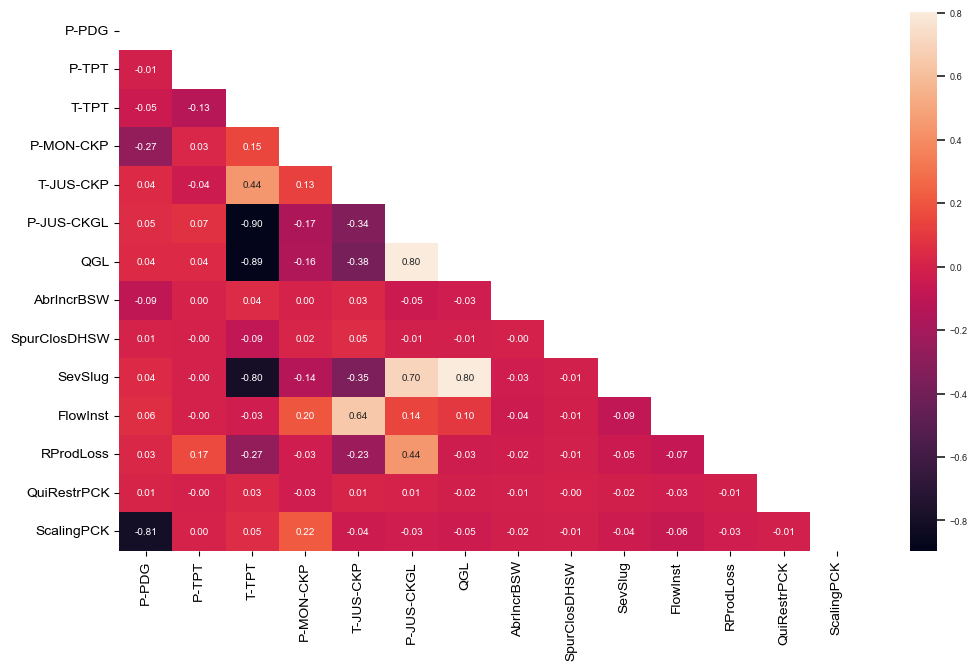

In [25]:
# Computing the correlations
corr = df.corr()

# Creating a boolean mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotting the heatmap with the mask
fig, ax = plt.subplots(figsize=(12, 7))
sns.set(font_scale=0.6)
sns.heatmap(corr, annot=True, mask=mask, ax=ax, fmt='.2f')
plt.show()

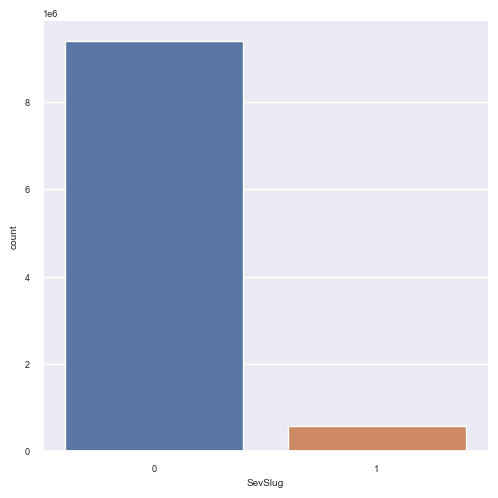

In [33]:
sns.catplot(data=df, x="SevSlug", kind="count")

### Handling Imbalanced Data

### Data Scaling

## Dimensionality Reduction

## Machine Learning

## Conclusion

Ideas:
* study basic time series analysis and consider frozen variables